In [1]:
using AveragedCircuitEigenvalueSampling, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio;

In [3]:
# Function to optimise the number of repetitions for each gate eigenvalue
function opt_merit(F::Function, lambda_array::Vector{Float64}; scale_factor=1e10)
    phi_float_array = ones(Float64, length(lambda_array))
    phi_array = ones(Int, length(lambda_array))
    F_array = zeros(length(lambda_array))
    for (idx, lambda) in enumerate(lambda_array)
        result = Optim.optimize(x -> (1/(1-lambda)) * F(x, lambda), [1/(1-lambda)], method=LBFGS(); autodiff=:forward)
        phi_float_array[idx] = abs(Optim.minimizer(result)[1])
        phi_floor = floor(phi_float_array[idx])
        phi_ceil = ceil(phi_float_array[idx])
        F_floor = F(phi_floor, lambda)
        F_ceil = F(phi_ceil, lambda)
        if F_floor < F_ceil
            phi_array[idx] = phi_floor
            F_array[idx] = F_floor
        else
            phi_array[idx] = phi_ceil
            F_array[idx] = F_ceil
        end
    end
    return (F_array::Vector{Float64}, phi_array::Vector{Int}, phi_float_array::Vector{Float64})
end;

In our depolarising noise model, measurements take $\tau=660/29$ longer than gates, the measurement noise eigenvalue is $\lambda_m=0.96$, and the single-qubit gate eigenvalue is $\lambda=0.999$.
In the toy example we consider here, the figure of merit at a particular gate eigenvalue $\lambda$ as a function of the number of gate repetitions $\phi$ is given by
$$
\mathcal{F}(\phi,\lambda)=\sqrt{\frac{(2\tau+1)}{4\tau(\tau+1)}}\frac{\lambda}{\phi}\left(\!\sqrt{\tau(1-\lambda_m^2)}+\sqrt{(\tau+\phi)(\lambda^{-2\phi}-\lambda_m^2)}\right).
$$
Without accounting for the time taken to implement circuits, we instead have
$$
\mathcal{F}(\phi,\lambda)=\frac{\lambda}{\sqrt{2}\phi}\left(\!\sqrt{1-\lambda_m^2}+\sqrt{\lambda^{-2\phi}-\lambda_m^2}\right).
$$
We will numerically optimise the number of repetitions $\phi$ for a given gate eigenvalue $\lambda$ to minimise the figure of merit $\mathcal{F}$, demonstrating that ACES is capable of relative precision noise estimation.

In [4]:
# Initialise parameters
tau = (660/29)
m = 0.96
log_lambda_min = -6
log_lambda_delta = 0.001
log_lambda_max = -2
lambda_array = reverse(1 .- 10.0 .^ (log_lambda_min:log_lambda_delta:log_lambda_max))
# Sample-optimised figure of merit
F(phi, lambda) = (lambda / (sqrt(2) * abs(phi[1]))) * (sqrt(1 - m^2) + sqrt(lambda^(-2 * abs(phi[1])) - m^2))
(F_array, phi_array, phi_float_array) = opt_merit(F, lambda_array)
# Time-optimised figure of merit
F_full(phi, lambda) = (lambda / abs(phi[1])) * sqrt((2 * tau + 1) / (4 * tau * (tau + 1))) * (sqrt(tau * (1 - m^2)) + sqrt((tau + abs(phi[1])) * (lambda^(-2 * abs(phi[1])) - m^2)))
(F_full_array, phi_full_array, phi_full_float_array) = opt_merit(F_full, lambda_array)
# Basic figure of merit (accounts for time)
F_basic_array = [F_full([1.0], lambda) for lambda in lambda_array];

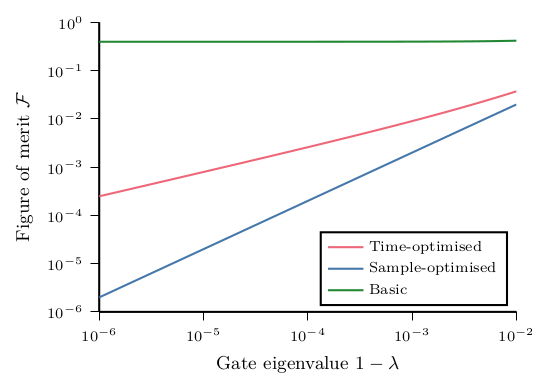

In [5]:
# Plot the figure of merit
merit_plot = plot(; size=(col_width_px * 1.0, col_height_px * 1.0),
    xaxis=:log10, xguide=L"\textrm{Gate eigenvalue }1-\lambda",
    xticks = 10.0.^(-6:-2), xlims=(10^(-6), 10^(-2)),
    yaxis=:log10, yguide=L"\textrm{Figure of merit }\mathcal{F}",
    yticks = 10.0.^(-6:0), ylims=(10^(-6), 1),
    legend=:bottomright, legend_font_halign=:left)
plot!(1 .- lambda_array, F_full_array; label="Time-optimised", color=colour_series[3])
plot!(1 .- lambda_array, F_array; label="Sample-optimised", color=colour_series[2])
plot!(1 .- lambda_array, F_basic_array; label="Basic", color=colour_series[1])
savefig(merit_plot, pwd() * "/figures/toy_merit.pdf")
display(merit_plot)

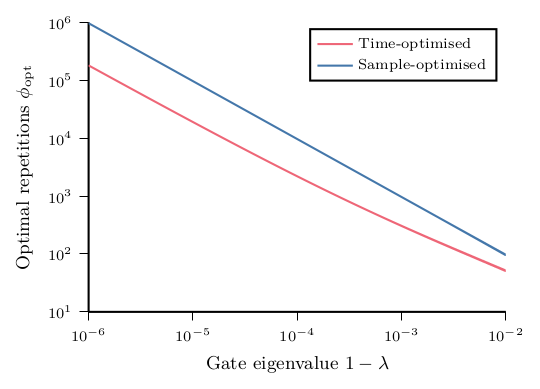

In [6]:
# Plot the optimal number of gate repetitions
phi_plot = plot(; size=(col_width_px * 1.0, col_height_px * 1.0),
    xaxis=:log10, xguide=L"\textrm{Gate eigenvalue }1-\lambda",
    xticks = 10.0.^(-6:-2), xlims=(10^(-6), 10^(-2)),
    yaxis=:log10, yguide=L"\textrm{Optimal repetitions }\phi_{\mathrm{opt}}",
    yticks = 10.0.^(1:6), ylims=(10^1, 10^6),
    legend=:topright, legend_font_halign=:left)
plot!(1 .- lambda_array, phi_full_array; label="Time-optimised", color=colour_series[3])
plot!(1 .- lambda_array, phi_array; label="Sample-optimised", color=colour_series[2])
savefig(phi_plot, pwd() * "/figures/toy_repetitions.pdf")
display(phi_plot)

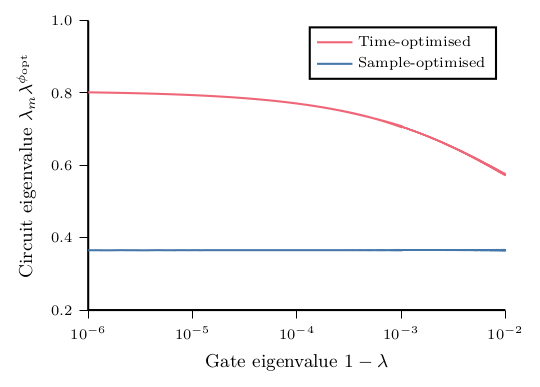

In [7]:
# Plot the optimal circuit eigenvalue
eigenvalue_plot = plot(; size=(col_width_px * 1.0, col_height_px * 1.0),
    xaxis=:log10, xguide=L"\textrm{Gate eigenvalue }1-\lambda",
    xticks = 10.0.^(-6:-2), xlims=(10^(-6), 10^(-2)),
    yguide=L"\textrm{Circuit eigenvalue }\lambda_m\lambda^{\phi_{\mathrm{opt}}}",
    yticks = 0.2:0.2:1.0, ylims=(0.2, 1.0),
    legend=:topright, legend_font_halign=:left)
idx = round(Int, 1/log_lambda_delta)
plot!(1 .- lambda_array[idx-10:end], m * lambda_array[idx-10:end] .^ phi_full_array[idx-10:end]; label="Time-optimised", color=colour_series[3])
scatter!(1 .- lambda_array[1:idx], m * lambda_array[1:idx] .^ phi_full_array[1:idx]; label = nothing, markersize=0.5, markerstrokealpha=0.0, color=colour_series[3])
plot!(1 .- lambda_array[idx-10:end], m * lambda_array[idx-10:end] .^ phi_array[idx-10:end]; label="Sample-optimised", color=colour_series[2])
scatter!(1 .- lambda_array[1:idx], m * lambda_array[1:idx] .^ phi_array[1:idx]; label = nothing, markersize=0.5, markerstrokealpha=0.0, color=colour_series[2])
savefig(eigenvalue_plot, pwd() * "/figures/toy_circuit_eigenvalue.pdf")
display(eigenvalue_plot)

In [8]:
# Initialise parameters
asymp_log_lambda_min = -12
asymp_log_lambda_max = -8
asymp_lambda_array = reverse(1 .- 10.0 .^ (asymp_log_lambda_min:log_lambda_delta:asymp_log_lambda_max))
(asymp_F_full_array, asymp_phi_full_array) = opt_merit(F_full, asymp_lambda_array)[1:2]
(asymp_F_array, asymp_phi_array) = opt_merit(F, asymp_lambda_array)[1:2]
# Show the optimal number of repetitions for the usual lambda value
idx = 1000
@assert lambda_array[idx+1] == 0.999
println("The optimal number of repetitions for λ = 0.999, accounting for gate times, is $(phi_full_array[idx+1]).")
println("The asymptotic time-optimised circuit eigenvalue is $(round(m * (asymp_lambda_array[end] ^ asymp_phi_full_array[end]), digits=6)).")
println("To achieve this circuit eigenvalue at λ = 0.999, we require $(round(Int, log(asymp_lambda_array[end] ^ asymp_phi_full_array[end]) / log(lambda_array[idx+1]))) repetitions.")

The optimal number of repetitions for λ = 0.999, accounting for gate times, is 306.
The asymptotic time-optimised circuit eigenvalue is 0.804193.
To achieve this circuit eigenvalue at λ = 0.999, we require 177 repetitions.


In [9]:
# Fit the figure of merit accounting for gate times
F_full_model = lm(@formula(y ~ x), DataFrame(x=log10.(1 .- asymp_lambda_array), y=log10.(asymp_F_full_array)))


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.606315  0.000190965  -3175.01    <1e-99  -0.60669   -0.605941
x             0.500042  1.89704e-5   26359.09    <1e-99   0.500005   0.500079
─────────────────────────────────────────────────────────────────────────────

In [10]:
# Fit the figure of merit
F_model = lm(@formula(y ~ x), DataFrame(x=log10.(1 .- asymp_lambda_array), y=log10.(asymp_F_array)))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error                t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.300214  9.96785e-11    3011826590.71    <1e-99   0.300214   0.300214
x            1.0       9.90202e-12  100989511167.24    <1e-99   1.0        1.0
───────────────────────────────────────────────────────────────────────────────────